# PMOIRED example #4: how to synthesize VLTI data; Keplerian disk in emission line; fitting AMBER observations of a Be star.

PMOIRED allows to create synthetic data based either on a model (using the PMOIRED syntax, see [PMOIRED model syntax with illustration](https://github.com/amerand/PMOIRED/blob/master/examples/Model%20definitions%20and%20examples.ipynbhttps://github.com/amerand/PMOIRED/blob/master/examples/Model%20definitions%20and%20examples.ipynb)), or using images/cubes. In this example, we show:
-  [How to synthesize VLTI data from a data cube](#formating) (2D image x wavelenhgth). For this we use [AMHRA](https://amhra.oca.eu/AMHRA/index.htmhttps://amhra.oca.eu/AMHRA/index.htm) service and in particular the [Be model star+Keplerian disk](https://amhra.oca.eu/AMHRA/bedisk/input.htmhttps://amhra.oca.eu/AMHRA/bedisk/input.htm) as described in [Delaa et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..87D/abstract)
-  [How to use the builtin Keplerian model in `PMOIRED` to fit the synthetic data](#modeling). The model is a re-implemtation of [Delaa et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..87D/abstract). We check that the results are identical in visibility space. 
- [We use the validated `PMOIRED` model to fit AMBER observations](#alphaCol) from Be star $\alpha~$Col published in [Meilland et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012A%26A...538A.110M/abstract), which were analysed with the [Delaa et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..87D/abstract) original model.

`PMOIRED` implementation differs from the one [Delaa et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..87D/abstract) in one aspect.`PMOIRED` implementation of the Keplerian disk is not optimised to produce images. The`PMOIRED` version computes fast and accurate visibilities. The disk is meshed on an irregular grid adapted to the disk velocity field: points are computed only at the surface of the disk, and the grid is finer in the inner part, where the speed varies faster than in the outer part of the disk. Images, as always in `PMOIRED`, are not used to compute visibilities and are interpolated for the pixel grid. This process may introduce artefacts which may lead to the wrong conclusion while comparing implementations: the comparision should be done in visibility space.

https://github.com/amerand/PMOIRED - Antoine Mérand (amerand@eso.org)

In [1]:
try:
    # -- jupyter lab
    %matplotlib widget
except:
    # -- jupyter notebook
    %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
try:
    # -- global installation
    import pmoired
    print('global')
except:
    # -- local installation
    import sys
    sys.path = ['../'] + sys.path
    import pmoired
    print('local')
from astropy.io import fits
import scipy.signal

[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
local


<a id='formating'></a>
# Models and formating data cube

The model we use is the [Be model star+Keplerian disk](https://amhra.oca.eu/AMHRA/bedisk/input.htmhttps://amhra.oca.eu/AMHRA/bedisk/input.htm) from [AMHRA](https://amhra.oca.eu/AMHRA/index.htmhttps://amhra.oca.eu/AMHRA/index.htm). We use the default parameters ("Pre-fill the fields with default values"), except for the profile of the disks: select "gaussian" instead of "uniform ellipse"

To be understood by `PMOIRED`, the model needs to be organised in a dictionnary `cube` containing at least:
 - `image` contains the 2D image or the 3D cube (3rd dim is wavelength). Pixels must be square!  
 - `X`, `Y`: 2D coordianates of the image X= in mas towards East; Y= in mas towards North
 - `WL`: the wavelength table, in microns
 - `scale`: the pixel size, in mas
 
The dictionnary can contain other information in case you want to keep track of the input file. Note that the function `readCube` below also allows to scale and rotate the cube. The function `showCube` shows some slices of the cube.

actual pixel size: 0.055mas
total field of view: 14.0mas x 14.0mas
spectral channel resolution: R=8023.6


{'Global simulation parameters': {'size of the simulation in pixel': '256',
  'field of view in D*': '30.000000',
  'number of wavelengths': '51',
  'line central wavelength in angstrom': '21661.000000',
  'delta lam in angstroms': '2.700000',
  'Resolution in angstroms 14 for AMBER MR and 1.8 for AMBER HR, 1.3 for VEGA': '5.400000'},
 'Central Star': {'inclination angle': '45.000000',
  'Rstar in solar radii': '5.000000',
  'distance in pc': '100.000000',
  'file for stellar flux variation in the line': 'none'},
 'Disk geometry in the continuum': {'gauss, uniform, or map': 'gauss',
  'major-axis FWHM or diameter in D*': '2.000000',
  'disk P.A': '60.000000',
  'file for the envelope continuum map': 'none',
  'envelope relative flux in the continuum': '0.500000'},
 'Disk geometry in the line': {'line equivalent width in Angstroms': '10.000000',
  'gauss, uniform, or map': 'gauss',
  'major-axis FWHM or diameter in D* (> 0)': '5.000000',
  'file for the envelope line map': 'none'},
 'Ki

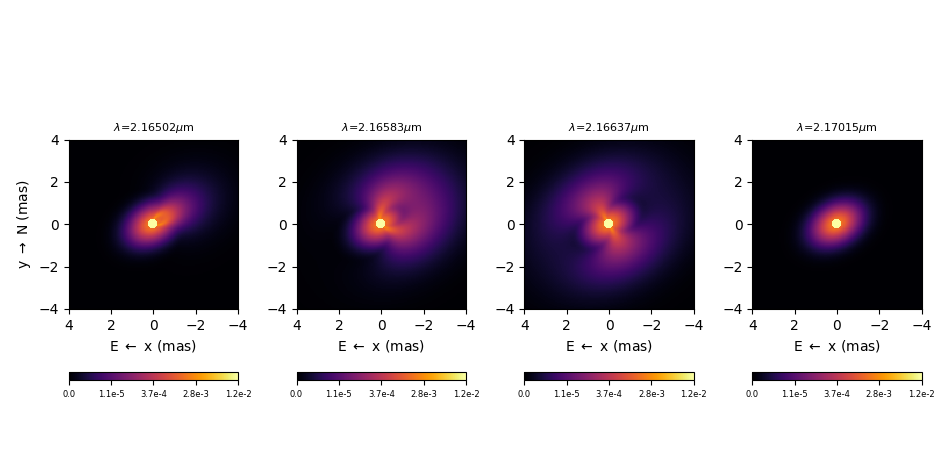

In [2]:
def readCube(filename, binning=None, rescale=1, rotation=0):
    """
    filename: FITS file containing the cube with first 2 dimensions are spatial dimensions, and third is the wavelength
    binning: bin the model if it is overresolved compared to what is needed (accelerate computations)
    rescale: scale the model by this factor, default 1.
    rotation: rotate the model on sky around 0,0 (degrees)
    """
    cube = {}
    m = fits.open(filename)
    x = (m[0].header['CRVAL1'] + (np.arange(m[0].header['NAXIS1'])+1-m[0].header['CRPIX1'])*m[0].header['CDELT1'])
    y = (m[0].header['CRVAL2'] + (np.arange(m[0].header['NAXIS2'])+1-m[0].header['CRPIX2'])*m[0].header['CDELT2'])
    
    # -- we need scales in mas
    sf = {'rad':180/np.pi*3600*1000, 'deg':3600*1000, 'arcsec':1000, '"':1000, 'mas':1.0}
    
    sx = sf[m[0].header['CUNIT1'].strip()]
    sy = sf[m[0].header['CUNIT2'].strip()]
    x *= sx*rescale
    y *= sy*rescale
    assert m[0].header['CDELT1']*sx==m[0].header['CDELT2']*sy, "pixels must be square!"
    
    cube['scale'] = np.abs(m[0].header['CDELT1']*rescale*sx) # mas / pixel
    print('actual pixel size: %.3fmas'%cube['scale'])
    print('total field of view: %.1fmas x %.1fmas'%(cube['scale']*m[0].header['NAXIS1'], cube['scale']*m[0].header['NAXIS2']))
    
    cube['X'], cube['Y'] = np.meshgrid(x, y)
    cube['X'], cube['Y'] = np.cos(rotation*np.pi/180)*cube['X'] + np.sin(rotation*np.pi/180)*cube['Y'], \
                          -np.sin(rotation*np.pi/180)*cube['X'] + np.cos(rotation*np.pi/180)*cube['Y']
    cube['rotation'] = rotation
    cube['image'] = m[0].data.copy()
    cube['WL'] = m[0].header['CRVAL3'] + (np.arange(m[0].header['NAXIS3'])+1-m[0].header['CRPIX3'])*m[0].header['CDELT3']
    # -- we need wavelength in microns
    if m[0].header['CUNIT3'].strip()=='m':
        cube['WL'] *= 1.e6
    print('spectral channel resolution: R=%.1f'%(np.mean(cube['WL']/np.gradient(cube['WL']))))

    if not binning is None:
        print('binning')
        n = binning
        r = np.linspace(-2,2,2*(n//2)+1)
        xp, yp = np.meshgrid(r,r)
        kernel = np.exp(-(xp**2+yp**2))        
        cube['X'] = scipy.signal.convolve2d(cube['X'], kernel/np.sum(kernel), mode='valid')[::n,::n]
        cube['Y'] = scipy.signal.convolve2d(cube['Y'], kernel/np.sum(kernel), mode='valid')[::n,::n]
        cube['scale'] *= n
        tmp = []
        for i in range(cube['image'].shape[0]):
            #print('convolving', i+1, '/', cube['image'].shape[0])
            tmp.append(scipy.signal.convolve2d(cube['image'][i], kernel, mode='valid')[::n,::n])
        cube['image'] = np.array(tmp)
        print(cube['image'].shape)
    m.close()
    return cube

def showCube(cube, imWl0=None, fig=0, imPow=1.0, imMax='100', cmap='inferno', 
             contour=False, lvl=None):
    """
    simple plot for cubes
    imWl0: list of wavelength to show. If integers, index of slices
    imPow: power law for image brightness scaling
    imMax: max cut for image (percentile if a string)
    
    """
    if imWl0 is None:
        imWl0 = [len(cube['WL'])//2]
        
    plt.close(fig)
    plt.figure(fig, figsize=(min(3.5*len(imWl0), 9.5),4.5))
    axs = []
    for i, iwl in enumerate(imWl0):
        if i==0:
            axs.append(plt.subplot(1,len(imWl0),1+i, aspect='equal'))
            plt.ylabel(r'y $\rightarrow$ N (mas)')
        else:
            axs.append(plt.subplot(1,len(imWl0),1+i, aspect='equal', sharex=axs[0], sharey=axs[0]))
        plt.xlabel(r'E $\leftarrow$ x (mas)')

        # -- if actual wavelength, convert to index
        if type(iwl)!=int:
            iwl = np.argmin(np.abs(np.array(cube['WL'])-iwl))
        # -- truncate the brightest part of the image if need be
        if type(imMax)==str:
            vmax=np.percentile(cube['image'][iwl]**imPow, float(imMax))
        elif not imMax is None:
            vmax = imMax
            
        if contour:
            plt.contour(cube['X'], cube['Y'], cube['image'][iwl]**imPow, 
                        lvl*vmax, # relative levels
                        cmap=cmap, vmax=vmax, vmin=0)
        else:
            plt.pcolormesh(cube['X'], cube['Y'], cube['image'][iwl]**imPow, 
                           cmap=cmap, vmax=vmax, vmin=0)
            cb = plt.colorbar(orientation='horizontal')
            Xcb = np.linspace(0,1,5)*vmax
            XcbL = ['%.1e'%(xcb**(1./imPow)) for xcb in Xcb]
            XcbL = [xcbl.replace('e+00', '').replace('e-0', 'e-') for xcbl in XcbL]
            cb.set_ticks(Xcb)
            cb.set_ticklabels(XcbL)
            cb.ax.tick_params(labelsize=6)
                
        plt.title('$\lambda$=%.5f$\mu$m'%cube['WL'][iwl], fontsize=8)
    axs[0].invert_xaxis()
    plt.tight_layout()
    return axs
    
def readParam(filename):
    with open(filename) as f:
        cube['param'] = {}
        for l in f.readlines():
            if l.startswith(';'):
                k1 = l[1:].strip()
                cube['param'][k1] = {}
            else:
                if len(l)>1 and ';' in l:
                    k2 = l.split(';')[1].strip()
                    cube['param'][k1][k2] = l.split(';')[0]
    return cube['param']

cube = readCube('BeModelsAMHRA/output_Be_1675260915739.fits') 
cube['param'] = readParam('BeModelsAMHRA/input_Be_1675260915739.txt')

# -- parameters of the model
display(cube['param'])

showCube(cube, imWl0=[2.1650, 2.1658, 2.1664, 2.1701], imMax='100', imPow=0.2, fig=100)
plt.xlim(4, -4); plt.ylim(-4, 4);

<a id='synthesize'></a>
# Creating interferometric data with VLTI baselines

the module `pmoired.oifake` allows to create fake VLTI data with a realistic u,v coverage and but simplistic noise model. The VLTI configuration is defined by a list of stations, the sky coordinate of the object, a list of LST, and a list of wavelength. If the object is not observable, the data will not be generated. 

The wavelength of the data can be different from the model, however it is mandatory that the `cube`'s wavelength sampling not being too much finer than the data, as `oifake` does not handle wavelength smearing, only interpolation. 

In [10]:
from importlib import reload
reload(pmoired.oifake)

<module 'oifake' from '/Users/amerand/Codes/PYTHON3/PMOIRED/examples/../pmoired/oifake.py'>

spectral resolution: R=8024


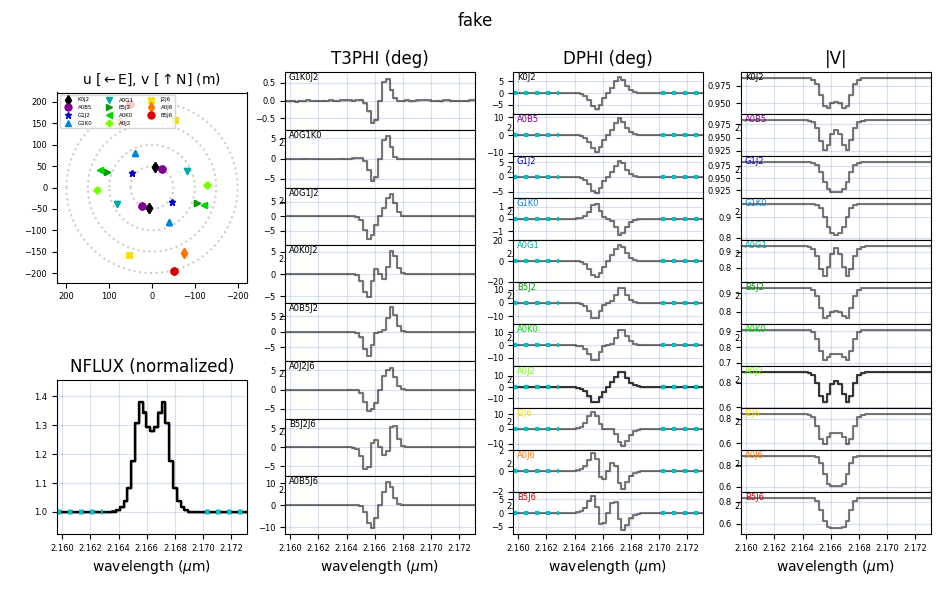

In [11]:
# -- same wavelength as model
wl = cube['WL']

# -- arbitrary wavelength vector, data synthesizer will interpolate
#wl = np.linspace(2.1665-0.006, 2.1665+0.006, 50)

print('spectral resolution: R=%.0f'%(np.mean(wl/np.gradient(wl))))

# -- no noise -> cannot fit as the chi2 will be ~1/0 !!!
noise = 0

# -- simplistic noise model 
noise = {'|V|':0.01, # fractional error on visibility amplitude
         'V2':0.01, # fractional error on visibility squared amplitude
         'T3AMP':0.01, # fractional error on triple product amplitude
         'T3PHI':1.0, # error on triple product phase, in degrees
         'PHI':1.0, # error on phase, in degrees
         'FLUX':0.01 # fractional error on flux
        }
noise = {k:noise[k]/100 for k in noise}

data = [pmoired.oifake.makeFakeVLTI(['A0', 'G1', 'K0', 'J2'], # VLTI telescope configuration (use "U" for UTs)
                                    (0, -24), # Simbad name or sky coordiates as (ra_h, dec_d)
                                    [0], # list of LST for observations
                                    wl, # list of wavelength, in um
                                    cube=cube, # cube dictionnary (see above)
                                    noise=noise, # noise dictionnary (see above)
                                    ),
         pmoired.oifake.makeFakeVLTI(['A0', 'B5', 'J2', 'J6'], # VLTI telescope configuration (use "U" for UTs)
                                    (0, -24), # Simbad name or sky coordiates as (ra_h, dec_d)
                                    [0], # list of LST for observations
                                    wl, # list of wavelength, in um
                                    cube=cube, # cube dictionnary (see above)
                                    noise=noise, # noise dictionnary (see above)
                                    doubleDL=True, # for the extended array, doubling of DL is used
                                  ),        
       ]

oi = pmoired.OI() # create an empty PMOIRED OI object
oi.data = data # note that data needs to be a list, even if it has only a single element!
oi.setupFit({'obs':['T3PHI', 'DPHI', '|V|', 'NFLUX'], # observable to display
            'continuum ranges':[(2.1, 2.163), (2.170, 2.2)] # manual definition of the continuum, only for display
            })
oi.show()

<a id='modeling'></a>
# Modeling the Keplerian disk with builtin Keplerian model in `PMOIRED`

First, we simulate the central star `star` with a uniform disk:
 -  `star,ud`: angular diameter in mas
 -  `star,f`: flux. Note that the equivalent width of the emission line assume a continuum of 1, so we have to define the flux of the star as function of of the flux of the continuum disk 

The continuum `disk` as a gaussian:
 -  `disk,fwhm`: gaussian of FWHM in mas
 -  `disk,incl`, `disk,projang`: the inclination (0==face one, 90==edge on) and projection angle (0==N, 90==E). Applied for the disk in the line and in the continuum. 
 -  `disk,f`: flux (flat continuum) 

The Keplerian disk `kep` has many parameters covering the line:
 -  `kep,incl`, `kep,projang`: the inclination (0==face one, 90==edge on) and projection angle (0==N, 90==E). Applied for the disk in the line and in the continuum.
 -  `kep,diamin`: the inner diameter of the disk in mas, usually defined as equal to the stellar diameter
 -  `kep,Vin`, `kep,beta`: inner rotation velocity (at diamin) in km/s, and power law for velocity radial variation (beta==-0.5 for Keplerian)
 -  `kep,line_1_fwhm`: the Full Width Half Maximum size of the disk in mas
 -  `kep,line_1_wl0`: central wavelength in um
 -  `kep,line_1_EW`: equivalent width of the line: <0 for absorption, >0 for emission. in nm. Note that the continuum flux needs to be 1 for the definition to hold!

Additionaly, several lines can be defined by replacing the `_1_` above by different numbers. As usual in `PMOIRED`, the names of the components (before the `,`) are arbitrary.

In the data plots below, black are the synthetic data (from AMHRA) and red is the `PMOIRED` model.

{'star,ud': 0.46504672609621567,
 'star,f': '1-$disk,f',
 'kep,incl': 45.0,
 'kep,projang': -60.0,
 'kep,diamin': '$star,ud',
 'kep,Vin': -500.0,
 'kep,line_1_fwhm': 2.3252336304810783,
 'kep,line_1_EW': 1.0,
 'kep,beta': -0.5,
 'kep,line_1_wl0': 2.16637,
 'disk,fwhm': 0.9300934521924313,
 'disk,f': 0.5,
 'disk,projang': '$kep,projang',
 'disk,incl': '$kep,incl'}

Vkepler images of shape (101, 101) for 51 wavelength bins: in 7.24s
Vkepler images of shape (101, 101) for 51 wavelength bins: in 7.15s


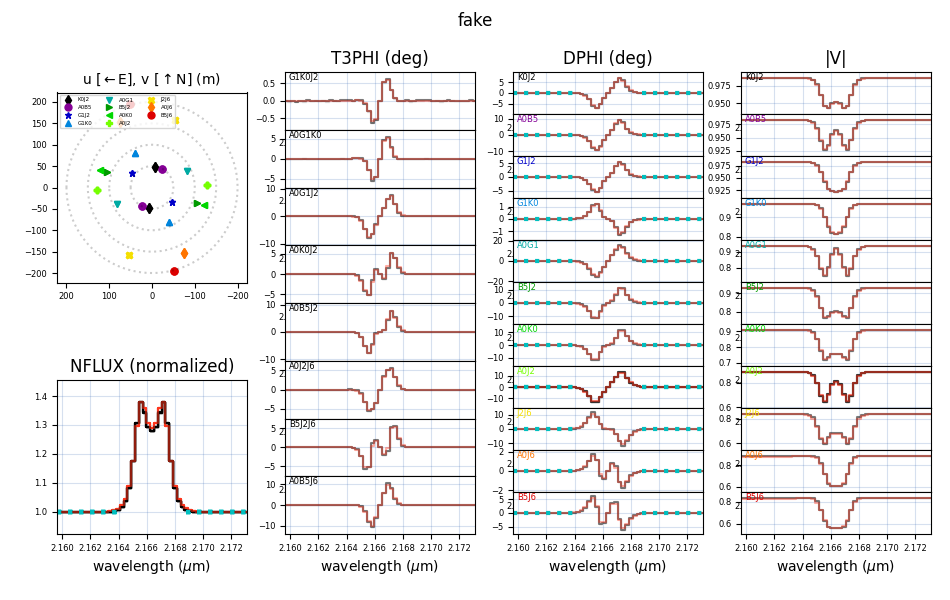

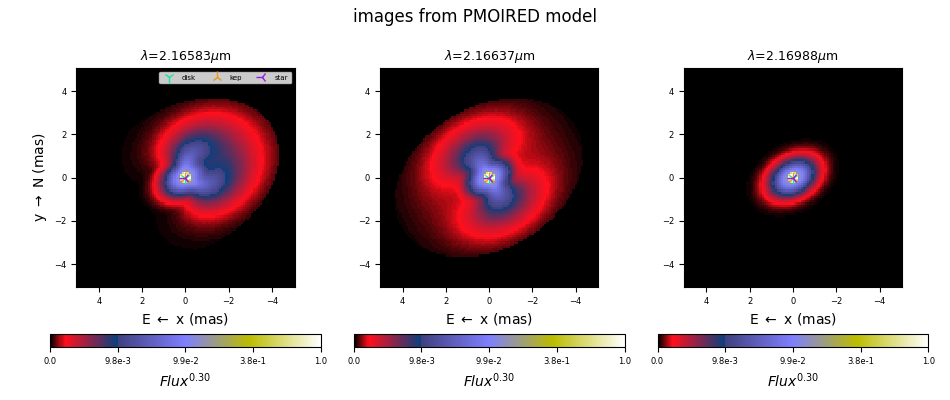

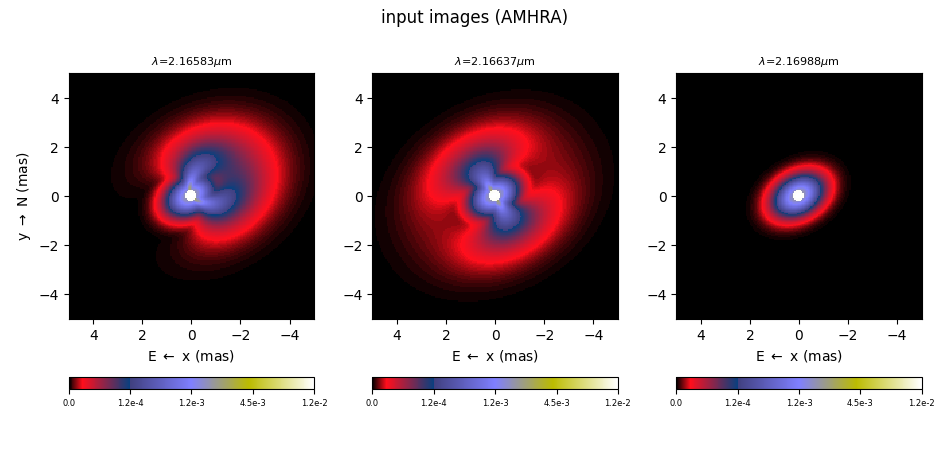

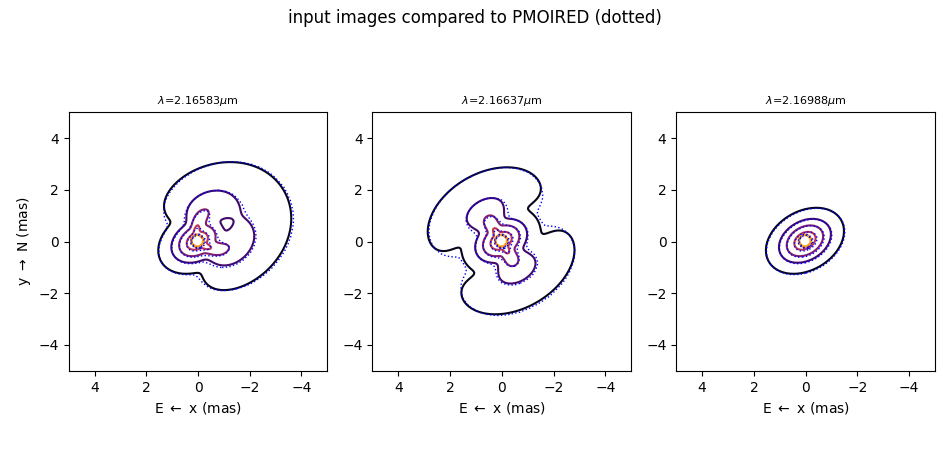

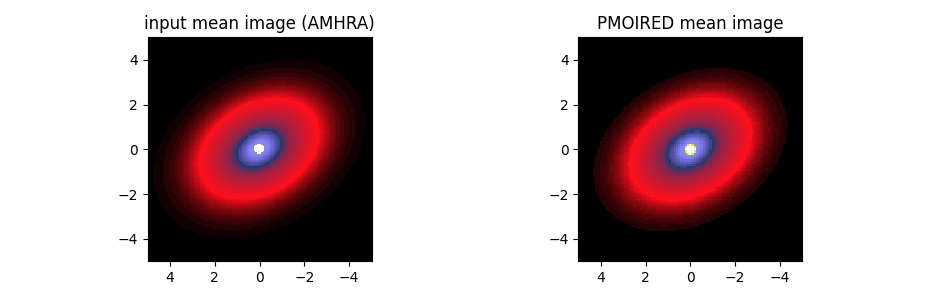

In [12]:
# == expected from simulation parameters
import astropy.units as U
# -- stellar angular diameter, in mas
diam = (2*float(cube['param']['Central Star']['Rstar in solar radii'])*U.Rsun/float(cube['param']['Central Star']['distance in pc'])/U.pc*U.rad).to(U.mas).value

# note that in the PMOIRED parametrisation, total continum flux need to be 1 so the EW keeps its definition
p  = {# -- central star
     'star,ud': diam,
     'star,f': '1-$disk,f',      
      # -- keplerian disk with emission
     'kep,incl': float(cube['param']['Central Star']['inclination angle']),
     'kep,projang': -float(cube['param']['Disk geometry in the continuum']['disk P.A']), # different convention?
     'kep,diamin': '$star,ud',
     'kep,Vin': -float(cube['param']['Kinematics']['stellar rotational velocity in km/s']), # <0 to set the rotation direction
     'kep,line_1_fwhm': float(cube['param']['Disk geometry in the line']['major-axis FWHM or diameter in D* (> 0)'])*diam,
     'kep,line_1_EW': float(cube['param']['Disk geometry in the line']['line equivalent width in Angstroms'])/10,     
     'kep,beta': float(cube['param']['Kinematics']['exponent of the rotational velocity law']),
     'kep,line_1_wl0': float(cube['param']['Global simulation parameters']['line central wavelength in angstrom'])/10000+
                     float(cube['param']['Global simulation parameters']['delta lam in angstroms'])/10000,
     # -- continuum disk
     'disk,fwhm': float(cube['param']['Disk geometry in the continuum']['major-axis FWHM or diameter in D*'])*diam,
     'disk,f': float(cube['param']['Disk geometry in the continuum']['envelope relative flux in the continuum']),
     'disk,projang':'$kep,projang', 'disk,incl':'$kep,incl'
    }
display(p)

oi.setupFit({'obs':['|V|', 'T3PHI', 'DPHI', 'NFLUX']})

# -- uncomment if you want to actually do a fit:
#oi.doFit(p, doNotFit=['disk,beta']); p = oi.bestfit['best']

# -- show data and PMOIRED model
imWl0 = [2.1658, 2.1664, 2.1700] # wavelength to plot (um)
imPow = 0.3 # using power law brightness scaling (1==linear, 0.5=square root, etc.)
oi.show(model=p, imFov=10, imWl0=imWl0, imMax='100', imPow=imPow, showSED=False, cmap='gist_stern')
plt.suptitle('images from PMOIRED model');  plt.tight_layout()

# -- image from initial parameters
axs = showCube(cube, imWl0=imWl0, imMax='100', imPow=imPow, fig=oi.fig+1, cmap='gist_stern')
plt.suptitle('input images (AMHRA)')
plt.xlim(5, -5); plt.ylim(-5, 5); plt.tight_layout()

# -- compare with PMOIRED using contour plots
lvl = np.linspace(0.05, 0.8, 6) # levels to plot
axs = showCube(cube, imWl0=imWl0, imMax='100', imPow=imPow, fig=oi.fig+2, contour=True, lvl=lvl)
plt.suptitle('input images compared to PMOIRED (dotted)')
plt.xlim(5, -5); plt.ylim(-5, 5); plt.tight_layout()

for i,ax in enumerate(axs):
    iwl = np.argmin(np.abs(oi.images['WL']-imWl0[i]))
    vmax = np.max(oi.images['cube'][iwl,:,:]**imPow)
    ax.contour(oi.images['X'], oi.images['Y'], oi.images['cube'][iwl,:,:]**imPow, lvl*vmax, 
               colors=['b'], linewidths=[1], linestyles=[':'])
plt.tight_layout()

# -- averaged image
plt.close(oi.fig+3)
plt.figure(oi.fig+3, figsize=(9.5, 3))
ax0 = plt.subplot(121, aspect='equal')
plt.pcolormesh(cube['X'], cube['Y'], cube['image'].mean(axis=0)**0.3, cmap='gist_stern')
plt.title('input mean image (AMHRA)')

ax1 = plt.subplot(122, aspect='equal', sharex=ax0, sharey=ax0)
plt.pcolormesh(oi.images['X'], oi.images['Y'], oi.images['cube'].mean(axis=0)**0.3, cmap='gist_stern')
plt.title('PMOIRED mean image')
plt.xlim(5, -5); plt.ylim(-5, 5); plt.tight_layout()

<a id='alphaCol'></a>

# Comparison to real data: AMBER observations of $\alpha$ Col

AMBER data from [Meilland et al (2012)](https://ui.adsabs.harvard.edu/abs/2012A%26A...538A.110M/abstract). The data used here (provided by A. Meilland), are not exactly the same than in the paper: they have been recalibrated. 

The goal of this section is to compare `PMOIRED` fit to the determined parameters reported in [table 5](https://www.aanda.org/articles/aa/full_html/2012/02/aa17955-11/T5.html) of the original paper. In that study, the parameters' estimation was done using a fine grid rather than a gradient descent fit, hence the `PMOIRED` fit is slightly more accurate.  

[P]arametric [M]odeling of [O]ptical [I]nte[r]ferom[e]tric [D]ata https://github.com/amerand/PMOIRED
loadOI: loading ./BeModelsAMHRA/ALPHACOL_2010-01-09T00_58.fits
  > insname: "AMBER" targname: "ALPCOL" pipeline: ""
  > MJD: (1,) [ 55205.043359489515 .. 55205.043359489515 ]
  > D0-H0-K0 | WL: (506,) [ 2.146 .. 2.194 ] um (R~22932) {'T3': 1, 'VIS': 3, 'VIS2': 3} | TELL: False 
loadOI: loading ./BeModelsAMHRA/ALPHACOL_2010-01-20T10_36.fits
  > insname: "AMBER" targname: "ALPCOL" pipeline: ""
  > MJD: (1,) [ 55216.075690134865 .. 55216.075690134865 ]
  > A0-G1-K0 | WL: (506,) [ 2.146 .. 2.194 ] um (R~22934) {'T3': 1, 'VIS': 3, 'VIS2': 3} | TELL: False 


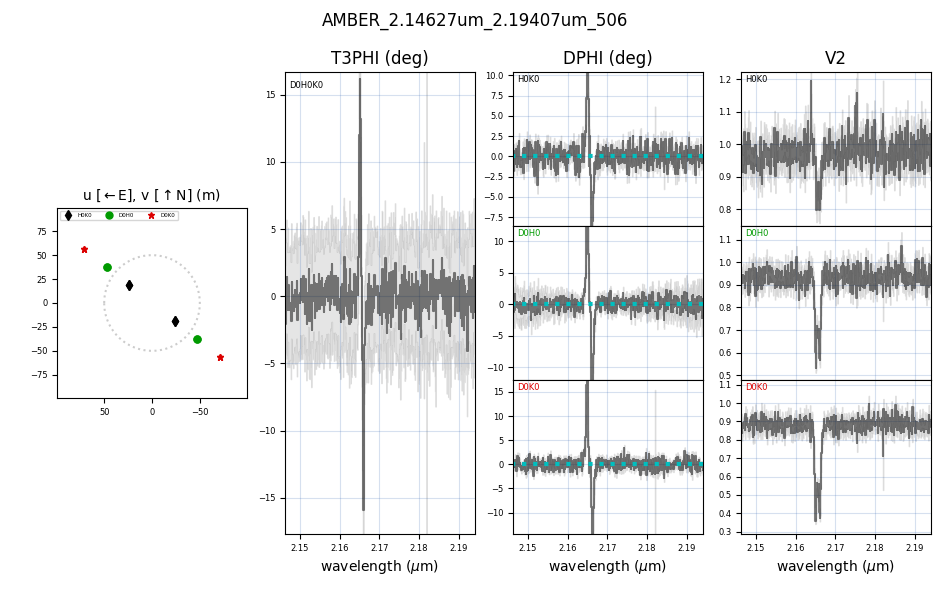

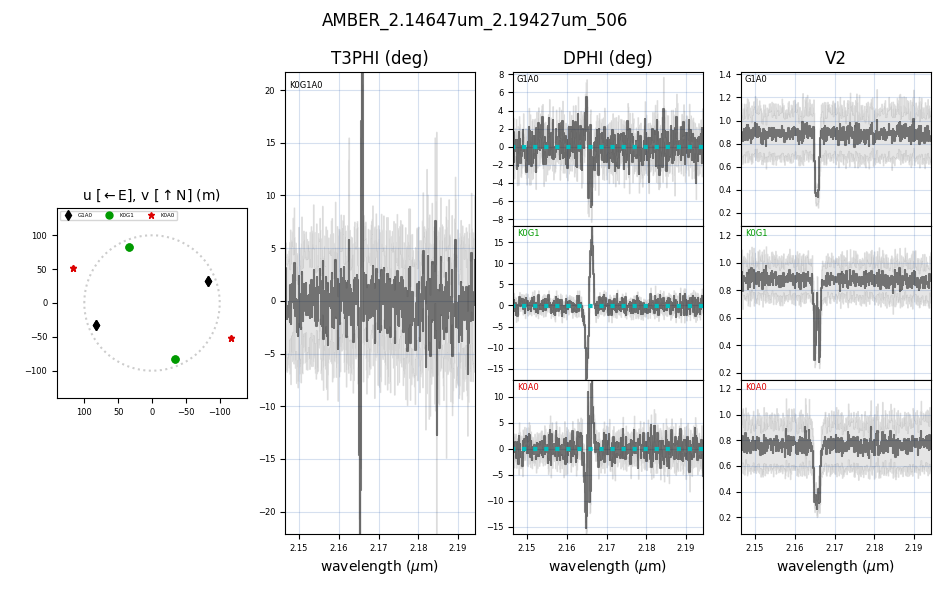

In [15]:
reload(pmoired)
# -- load data
oi = pmoired.OI(['./BeModelsAMHRA/ALPHACOL_2010-01-09T00_58.fits', 
                 './BeModelsAMHRA/ALPHACOL_2010-01-20T10_36.fits'])
oi.setupFit({'obs':['V2', 'DPHI', 'T3PHI']})
oi.show()

chi2 with Meilland+2012 parameters: 3.974
chi2 with best fit parameters     : 0.757
Vkepler images of shape (101, 101) for 70 wavelength bins: in 12.92s
Vkepler images of shape (101, 101) for 70 wavelength bins: in 14.62s


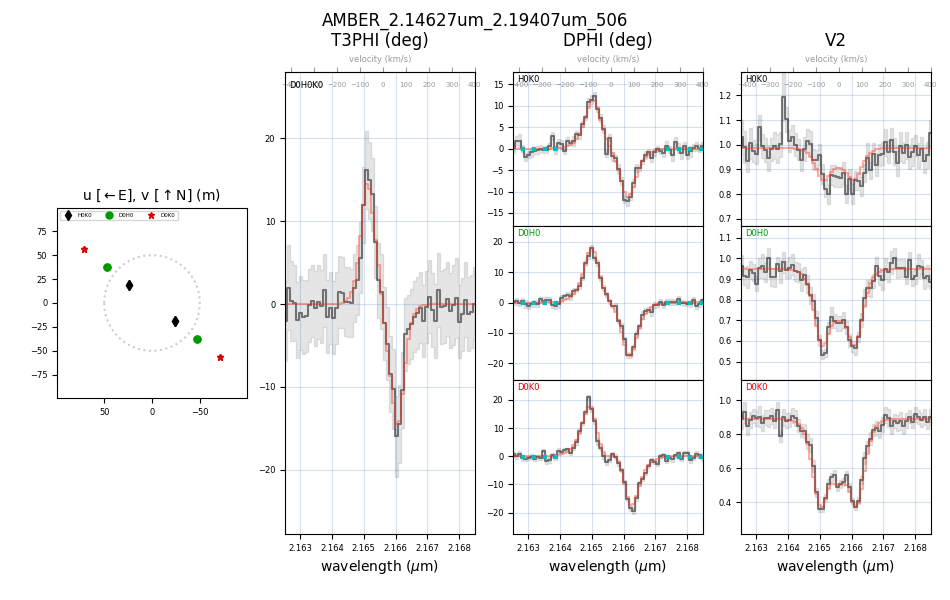

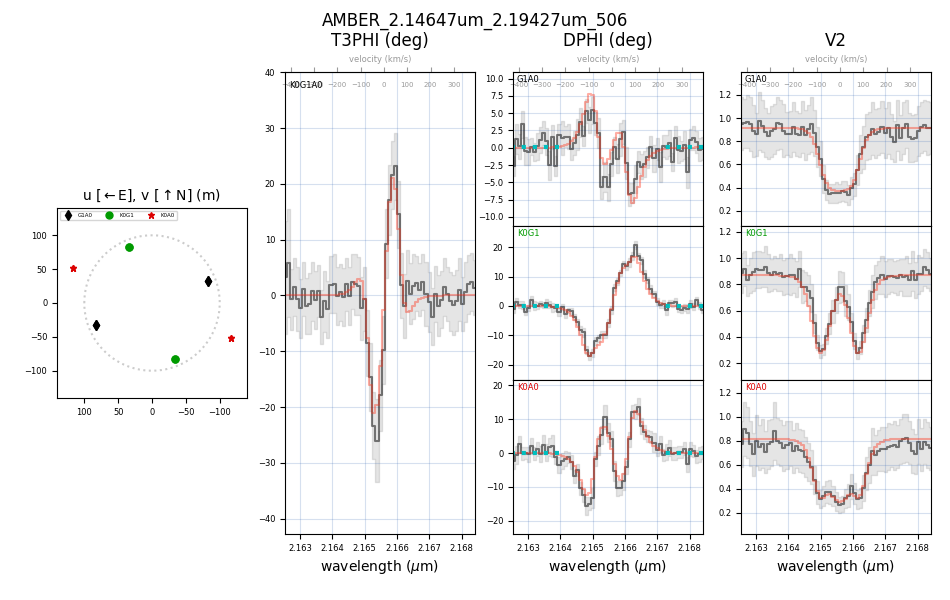

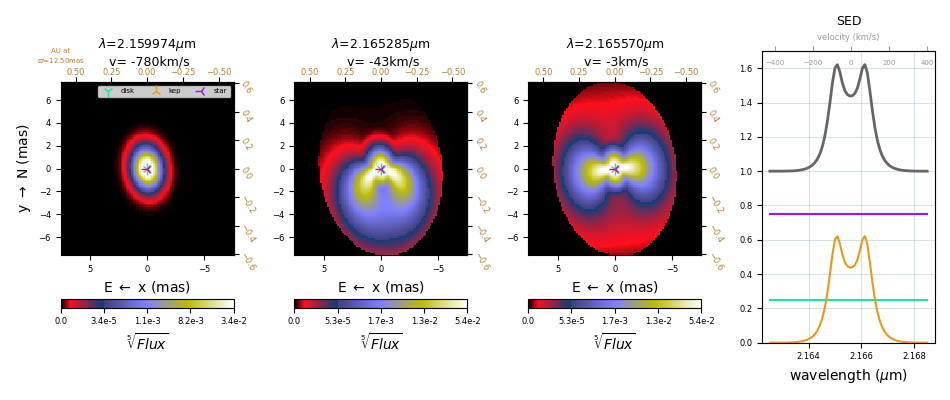

In [16]:
# -- fit only around the Brackett Gamma line
oi.setupFit({'obs':['V2', 'DPHI', 'T3PHI'], 
            'wl ranges':[(2.1655-0.003, 2.1655+0.003)]})

import astropy.units as U
# -- stellar angular diameter from paper, degenerate with continuum disk
diam = (2*5.8*U.Rsun/(80*U.pc)*U.rad).to(U.mas).value

# -- from Meilland 2012:
p = {
    'star,ud':        diam,
    'star,f':         '1-$disk,f',
    'ac': 2.0,
    'disk,fwhm':      '$ac*$star,ud', 
    'disk,f': 0.25,
    'disk,incl':      '$kep,incl',
    'disk,projang':   '$kep,projang',
    'kep,diamin':    '$star,ud',
    'kep,Vin':        350.,
    'kep,projang':    10, 
    'kep,incl':       35, 
    'kep,line_1_EW':  0.7, 
    'al': 5.5,
    'kep,line_1_fwhm': '$al*$star,ud', 
    'kep,line_1_wl0': 2.16562,
    'kep,beta':       -0.5,
}

# -- show the data compared to the parameters in the original paper
#oi.show(p) 

res = pmoired.oimodels.residualsOI(oi.data, p)
print('chi2 with Meilland+2012 parameters: %.3f'%np.mean(res**2))

if False:
    # === actually fit to the data =====================
    # -- "centered" parametrisation of wavelength, so fit converges efficiently
    p['kep,line_1_wl0'] = '2.16612*(1 + $V0/2.998e5)'
    p['V0'] = -70.0 # visually match the line
   
    # -- fit:
    oi.doFit(p, doNotFit=['star,ud', # degenerated with disk,fwhm and disk,f
                          'disk,f', # degenerated with disk,fwhm 
                          'kep,beta'], # assume Keplerian velocity field        
            )
    p = oi.bestfit['best']
else:
    # === best fit parameters from fit above ================
    # -- best fit: chi2~0.7532
    p = {'V0':             -73.01, # +/- 0.33
        'ac':             1.896, # +/- 0.064
        'al':             5.690, # +/- 0.051
        'kep,Vin':        360.54, # +/- 4.22
        'kep,incl':       45.58, # +/- 0.86
        'kep,line_1_EW':  1.038, # +/- 0.011
        'kep,projang':    6.84, # +/- 0.53
        'disk,f':         0.25,
        'disk,fwhm':      '$ac*$star,ud',
        'disk,incl':      '$kep,incl',
        'disk,projang':   '$kep,projang',
        'kep,beta':       -0.5,
        'kep,diamin':     '$star,ud',
        'kep,line_1_fwhm':'$al*$star,ud',
        'kep,line_1_wl0': '2.16612*(1 + $V0/2.998e5)',
        'star,f':         '1-$disk,f',
        'star,ud':        0.6743177528395127,
        }
    res = pmoired.oimodels.residualsOI(oi.data, p)
    print('chi2 with best fit parameters     : %.3f'%np.mean(res**2))
    
# -- evaluate string parameters
p = pmoired.oimodels.computeLambdaParams(p)
oi.show(p, imFov=15, imPow=0.2, imMax='99.5', imWl0=[2.16, p['kep,line_1_wl0']-0.0003, p['kep,line_1_wl0']], 
        vWl0=p['kep,line_1_wl0'], cmap='gist_stern', imPlx=12.5)